In [1]:
from minio import Minio
from dotenv import load_dotenv
import os
import json
import pandas as pd

In [2]:
load_dotenv()

minio_client = Minio(
    endpoint=os.getenv("MINIO_ENDPOINT"),
    access_key=os.getenv("MINIO_ACCESS_KEY"), 
    secret_key=os.getenv("MINIO_SECRET_KEY"), 
    secure=False 
)
bucket_name = os.getenv("MINIO_BUCKET_NAME")
pasta_prefix = "Portalnoticiasceara/noticias_recentes_ultimo_mes" 

In [3]:
list_objects = minio_client.list_objects(bucket_name, prefix=pasta_prefix, recursive=True)

In [4]:
objetos = [minio_client.get_object(bucket_name=bucket_name, object_name=obj.object_name) for obj in list_objects if obj.object_name.endswith('metadata.json')]

In [5]:
dataframes = []
for response in objetos:
    data = response.read().decode('utf-8')
    
    json_data = json.loads(data)
    df = pd.json_normalize(json_data)
    dataframes.append(df)  
final_dataframe = pd.concat(dataframes, ignore_index=True)  

In [6]:
final_dataframe.head()

,id,mensagem,data,media_path,faccao,bairro
0,6665,"**Duplo Homicídio no Bairro Aracapé, em Fortal...",2024-12-29 09:59:53,[Portalnoticiasceara/past_dates/2024-12-29/med...,GDE,planalto_ayrton_senna
1,6680,Homicídio a bala registrado neste domingo (29)...,2024-12-29 14:04:04,[Portalnoticiasceara/past_dates/2024-12-29/med...,None,jardim_das_oliveiras
2,6691,**Polícia militar age rápido e apreende acusad...,2024-12-29 16:53:10,[Portalnoticiasceara/past_dates/2024-12-29/med...,None,edson_queiroz
3,6700,CHOQUE COM POSTE COM VITIMA FATAL - RUA DEMET...,2024-12-29 18:09:19,[Portalnoticiasceara/past_dates/2024-12-29/med...,None,antonio_bezerra
4,6668,**Acidente registrado há poucos minutos na Bar...,2024-12-29 10:25:12,[Portalnoticiasceara/past_dates/2024-12-29/med...,None,barra_do_ceara


In [7]:
len(final_dataframe[final_dataframe['faccao'] == 'GDE'])

45

In [8]:
len(final_dataframe[final_dataframe['faccao'] == 'CV'])

70

In [9]:
len(final_dataframe[final_dataframe['faccao'] == 'TDN'])

29

In [10]:
df_one_hot = pd.get_dummies(final_dataframe[['mensagem', 'faccao']], columns=['faccao'])

In [11]:
df_one_hot.head()

,mensagem,faccao_CV,faccao_GDE,faccao_PCC,faccao_TDN
0,"**Duplo Homicídio no Bairro Aracapé, em Fortal...",False,True,False,False
1,Homicídio a bala registrado neste domingo (29)...,False,False,False,False
2,**Polícia militar age rápido e apreende acusad...,False,False,False,False
3,CHOQUE COM POSTE COM VITIMA FATAL - RUA DEMET...,False,False,False,False
4,**Acidente registrado há poucos minutos na Bar...,False,False,False,False


In [12]:
df_filtered = df_one_hot[(df_one_hot[['faccao_CV', 'faccao_GDE', 'faccao_TDN']].sum(axis=1) > 0)]

##### Anotações
- Remoção de Pontuação e Caracteres Especiais:
    Remover caracteres especiais e pontuação que não são importantes para o modelo.
- Lowercasing:
    Converter o texto para minúsculas para evitar duplicação devido à diferença de maiúsculas/minúsculas.
- Tokenização:
    Dividir o texto em palavras ou tokens.
- Remoção de Stop Words:
    Eliminar palavras comuns, como "a", "e", "o", que não trazem valor informativo.
- Lematização ou Stemming:
    Reduzir palavras a suas formas base (ex: "correr" e "correu" para "correr").

In [13]:
!pip install scikit-learn nltk

In [14]:
import string

stopwords_pt = ['a', 'o', 'e', 'é', 'de', 'em', 'que', 'para', 'com', 'um', 'na', 'no', 'se', 'os', 'as']
def preprocess_text_alternativo(text):

    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_pt]
    tokens = [t for t in tokens] 
    return ' '.join(tokens)


df_filtered['mensagem'] = df_filtered['mensagem'].apply(preprocess_text_alternativo)


/tmp/ipykernel_47043/4186501716.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['mensagem'] = df_filtered['mensagem'].apply(preprocess_text_alternativo)


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer



vectorizer = TfidfVectorizer(max_features=5000) 
X = vectorizer.fit_transform(df_filtered['mensagem'])  


In [16]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3517 stored elements and shape (144, 867)>

In [17]:
vectorizer

TfidfVectorizer(max_features=5000)

In [18]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, df_filtered[['faccao_CV', 'faccao_GDE', 'faccao_TDN']], test_size=0.2, random_state=42)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier


lr = LogisticRegression(max_iter=1000)
model = MultiOutputClassifier(lr)

model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [20]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score: {f1}')


F1 Score: 0.5216049382716049


In [21]:
!pip install seaborn matplotlib

Matriz de Confusão para a classe: faccao_CV
[[13  1]
 [ 4 11]]


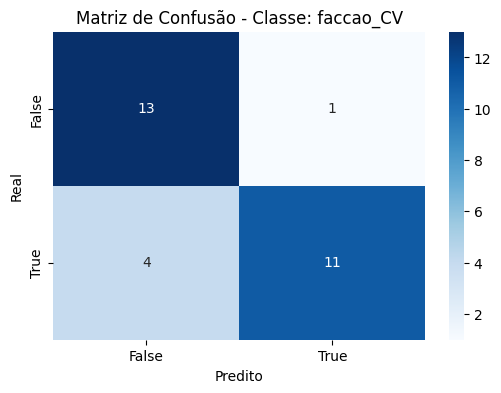

Matriz de Confusão para a classe: faccao_GDE
[[24  0]
 [ 2  3]]


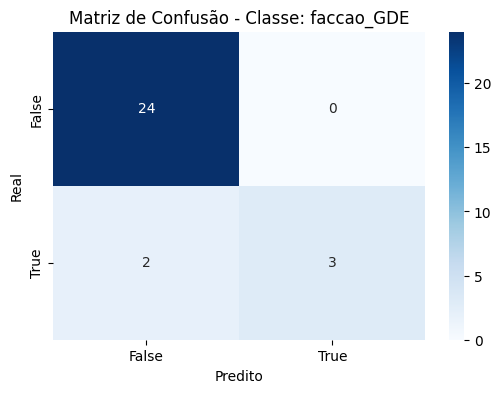

Matriz de Confusão para a classe: faccao_TDN
[[20  0]
 [ 9  0]]


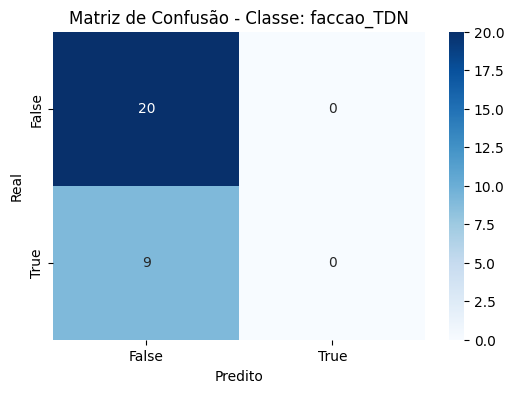

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


for i, column in enumerate(y_test.columns):
    print(f'Matriz de Confusão para a classe: {column}')
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title(f'Matriz de Confusão - Classe: {column}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
